In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, chi2_contingency, fisher_exact
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
import matplotlib.pyplot as plt

In [2]:
# Load the data 
df = pd.read_csv('sepsis_cleaned.csv')

In [3]:
df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'EDTime', 'HospTime', 'death',
       'gender', 'WHITE', 'WHITE - RUSSIAN', 'WHITE - EASTERN EUROPEAN',
       'WHITE - OTHER EUROPEAN', 'WHITE - BRAZILIAN', 'SOUTH AMERICAN',
       'ASIAN', 'ASIAN - KOREAN', 'ASIAN - CHINESE',
       'ASIAN - SOUTH EAST ASIAN', 'ASIAN - ASIAN INDIAN',
       'AMERICAN INDIAN/ALASKA NATIVE',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'HISPANIC OR LATINO',
       'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - DOMINICAN',
       'HISPANIC/LATINO - SALVADORAN', 'HISPANIC/LATINO - PUERTO RICAN',
       'HISPANIC/LATINO - COLUMBIAN', 'HISPANIC/LATINO - HONDURAN',
       'HISPANIC/LATINO - CENTRAL AMERICAN', 'HISPANIC/LATINO - CUBAN',
       'HISPANIC/LATINO - MEXICAN', 'PORTUGUESE', 'BLACK/AFRICAN AMERICAN',
       'BLACK/CAPE VERDEAN', 'BLACK/AFRICAN', 'BLACK/CARIBBEAN ISLAND',
       'OTHER', 'UNKNOWN', 'UNABLE TO OBTAIN', 'PATIENT DECLINED TO ANSWER',
       'hospital_expire_flag', 'BMI', 'weight',

In [4]:
df['qsofa'] = df['qsofa'].apply(lambda x: 1 if x > 2 else 0)

In [5]:
# Create some combined variables for later use
# create a new variable 'use of vasopressors'
df['use_of_vasopressors'] = df[['epinephrine', 'norepinephrine', 'dopamine', 'dobutamine']].sum(axis=1)
df['use_of_vasopressors'] = df['use_of_vasopressors'].apply(lambda x: 1 if x > 0 else 0)

In [6]:
# create a new variable 'Invasive ventilation'
df['invasive_ventilation'] = df[['tracheostomy', 'IV']].sum(axis=1)
df['invasive_ventilation'] = df['invasive_ventilation'].apply(lambda x: 1 if x > 0 else 0)

# create a new variable 'Non invasive ventilation'
df['non_invasive_ventilation'] = df[['NIV', 'HFNC']].sum(axis=1)
df['non_invasive_ventilation'] = df['non_invasive_ventilation'].apply(lambda x: 1 if x > 0 else 0)

In [7]:
df['po2_fio2_geq'] = df['po2/fio2'].apply(lambda x: 1 if x > 450 else 0)
df['gcs_geq'] = df['gcs'].apply(lambda x: 1 if x > 14 else 0)

In [8]:
# Set display options to show all columns without truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
df.tail()

,subject_id,hadm_id,stay_id,EDTime,HospTime,death,gender,WHITE,WHITE - RUSSIAN,WHITE - EASTERN EUROPEAN,WHITE - OTHER EUROPEAN,WHITE - BRAZILIAN,SOUTH AMERICAN,ASIAN,ASIAN - KOREAN,ASIAN - CHINESE,ASIAN - SOUTH EAST ASIAN,ASIAN - ASIAN INDIAN,AMERICAN INDIAN/ALASKA NATIVE,NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,HISPANIC OR LATINO,HISPANIC/LATINO - GUATEMALAN,HISPANIC/LATINO - DOMINICAN,HISPANIC/LATINO - SALVADORAN,HISPANIC/LATINO - PUERTO RICAN,HISPANIC/LATINO - COLUMBIAN,HISPANIC/LATINO - HONDURAN,HISPANIC/LATINO - CENTRAL AMERICAN,HISPANIC/LATINO - CUBAN,HISPANIC/LATINO - MEXICAN,PORTUGUESE,BLACK/AFRICAN AMERICAN,BLACK/CAPE VERDEAN,BLACK/AFRICAN,BLACK/CARIBBEAN ISLAND,OTHER,UNKNOWN,UNABLE TO OBTAIN,PATIENT DECLINED TO ANSWER,hospital_expire_flag,BMI,weight,age,myocardial_infarction,congestive_heart_failure,peripheral_vascular_disease,cerebrovascular_disease,dementia,chronic_pulmonary_disease,rheumatic_disease,peptic_ulcer_disease,mild_liver_disease,diabetes_without_chronic_complication,diabetes_with_chronic_complication,hemiplegia_or_paraplegia,renal_disease,malignancy,moderate_or_severe_liver_disease,metastatic_solid_tumor,AIDSHIV,hypertension,diabetes_mellitus,log2_num_admissions,log2_num_ED,log2_num_ED_admissions,WBC,platelet,log2_CRP,glucose,glucose_bg,lactate,creatinine,bilirubin,po2/fio2,gcs,epinephrine,norepinephrine,dopamine,dobutamine,tracheostomy,IV,NIV,HFNC,supplemental_oxygen,temperature,heartrate,resprate,o2sat,sbp,dbp,qsofa,use_of_vasopressors,invasive_ventilation,non_invasive_ventilation,po2_fio2_geq,gcs_geq
2140,18058493,24261370,32466427,0.068924,5.926389,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,26.400000,139.990000,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,9.800000,295,0.584963,142.0,85.0,2.30,1.0,0.5,450.0,15,0.0,0.0,0.0,0.0,0,0,0,0,1,37.777778,99.5,22.0,100.0,90.0,59.0,0,0,0,0,0,1
2141,18082025,25387142,33981750,0.189583,23.246528,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26.350000,167.821333,88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,4.600000,410,0.584963,109.0,85.0,1.35,0.4,0.7,450.0,15,0.0,0.0,0.0,0.0,0,1,0,0,1,37.222222,114.0,27.0,95.0,120.5,77.5,0,0,1,0,0,1
2142,18360993,28177289,37990608,0.284028,20.708333,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28.488889,147.555263,73,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,3.169925,3.584963,2.807355,14.000000,300,0.584963,127.0,85.0,2.90,1.3,0.7,252.0,15,0.0,24.0,0.0,0.0,0,1,0,1,1,36.944444,80.0,30.0,94.0,120.0,72.0,0,1,1,1,0,1
2143,18382120,28169687,30074352,0.268056,10.654861,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27.300000,185.190000,89,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0.000000,0.000000,0.000000,45.000000,242,0.584963,300.0,300.0,6.10,1.9,1.8,121.0,15,10.0,50.0,400.0,0.0,0,0,0,0,1,36.944444,56.0,18.0,97.0,98.5,51.0,0,1,0,0,0,1
2144,18555083,27516572,34788214,0.088762,16.823611,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42.500000,240.000000,37,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.000000,0.000000,0.000000,17.700001,335,0.584963,116.0,85.0,1.00,0.8,0.5,450.0,15,0.0,0.0,0.0,0.0,0,0,0,0,1,36.777778,113.0,18.0,97.0,113.0,73.0,0,0,0,0,0,1


In [9]:
df.head()

,subject_id,hadm_id,stay_id,EDTime,HospTime,death,gender,WHITE,WHITE - RUSSIAN,WHITE - EASTERN EUROPEAN,WHITE - OTHER EUROPEAN,WHITE - BRAZILIAN,SOUTH AMERICAN,ASIAN,ASIAN - KOREAN,ASIAN - CHINESE,ASIAN - SOUTH EAST ASIAN,ASIAN - ASIAN INDIAN,AMERICAN INDIAN/ALASKA NATIVE,NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,HISPANIC OR LATINO,HISPANIC/LATINO - GUATEMALAN,HISPANIC/LATINO - DOMINICAN,HISPANIC/LATINO - SALVADORAN,HISPANIC/LATINO - PUERTO RICAN,HISPANIC/LATINO - COLUMBIAN,HISPANIC/LATINO - HONDURAN,HISPANIC/LATINO - CENTRAL AMERICAN,HISPANIC/LATINO - CUBAN,HISPANIC/LATINO - MEXICAN,PORTUGUESE,BLACK/AFRICAN AMERICAN,BLACK/CAPE VERDEAN,BLACK/AFRICAN,BLACK/CARIBBEAN ISLAND,OTHER,UNKNOWN,UNABLE TO OBTAIN,PATIENT DECLINED TO ANSWER,hospital_expire_flag,BMI,weight,age,myocardial_infarction,congestive_heart_failure,peripheral_vascular_disease,cerebrovascular_disease,dementia,chronic_pulmonary_disease,rheumatic_disease,peptic_ulcer_disease,mild_liver_disease,diabetes_without_chronic_complication,diabetes_with_chronic_complication,hemiplegia_or_paraplegia,renal_disease,malignancy,moderate_or_severe_liver_disease,metastatic_solid_tumor,AIDSHIV,hypertension,diabetes_mellitus,log2_num_admissions,log2_num_ED,log2_num_ED_admissions,WBC,platelet,log2_CRP,glucose,glucose_bg,lactate,creatinine,bilirubin,po2/fio2,gcs,epinephrine,norepinephrine,dopamine,dobutamine,tracheostomy,IV,NIV,HFNC,supplemental_oxygen,temperature,heartrate,resprate,o2sat,sbp,dbp,qsofa,use_of_vasopressors,invasive_ventilation,non_invasive_ventilation,po2_fio2_geq,gcs_geq
0,10004322,20356134,36579193,0.254861,5.838889,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29.900000,179.890000,64,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,1.584963,1.584963,1.584963,19.799999,334,0.584963,158.0,85.0,1.35,1.2,0.4,450.000000,15,0.0,0.0,0.0,0.0,0,0,0,0,0,37.277778,111.5,23.5,99.0,107.0,58.0,0,0,0,0,0,1
1,10014729,23300884,37887480,0.183183,8.860417,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23.600000,150.000000,21,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,24.200001,332,0.584963,132.0,85.0,1.35,0.7,0.5,450.000000,15,0.0,0.0,0.0,0.0,0,0,0,0,0,37.444444,119.5,22.0,100.0,115.0,65.0,0,0,0,0,0,1
2,10019003,29279905,31254712,0.203472,10.704861,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33.200000,187.600000,70,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0.000000,0.000000,0.000000,50.000000,234,0.584963,258.0,85.0,4.60,2.5,0.3,185.714286,15,0.0,8.0,0.0,0.0,0,0,0,0,1,36.944444,96.0,21.5,97.5,102.0,52.0,0,1,0,0,0,1
3,10020944,29974575,39738665,0.141667,14.060417,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,27.977778,187.929444,72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,12.700000,166,0.584963,124.0,85.0,3.10,1.4,0.4,252.500000,15,0.0,8.0,0.0,0.0,0,1,0,0,1,37.000000,80.0,14.0,97.5,105.0,70.0,0,1,1,0,0,1
4,10030753,21257920,39742415,0.205556,10.531250,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.900000,125.200000,56,1,1,1,0,1,1,1,0,0,1,1,0,1,0,0,0,0,1,1,4.643856,4.247928,4.087463,10.400000,220,0.584963,300.0,85.0,1.60,2.5,0.5,450.000000,14,0.0,0.0,0.0,0.0,0,0,0,0,1,38.500000,121.0,26.0,96.0,160.0,83.0,0,0,0,0,0,0


In [10]:
df.shape

(2145, 96)

In [11]:
survivors = df[df['death'] == 0]
non_survivors = df[df['death'] == 1]

In [12]:
survivors.shape

(1824, 96)

In [13]:
non_survivors.shape

(321, 96)

In [14]:
categorical_variables = [
    'gender',
    'myocardial_infarction', 'congestive_heart_failure', 'peripheral_vascular_disease',
    'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease',
    'rheumatic_disease', 'peptic_ulcer_disease', 'mild_liver_disease',
    'diabetes_without_chronic_complication', 'diabetes_with_chronic_complication',
    'hemiplegia_or_paraplegia', 'renal_disease', 'malignancy',
    'moderate_or_severe_liver_disease', 'metastatic_solid_tumor', 'AIDSHIV', 'hypertension',
    'diabetes_mellitus', 'epinephrine', 'norepinephrine', 'dopamine', 'dobutamine', 'tracheostomy',
    'IV', 'NIV', 'HFNC', 'supplemental_oxygen', 'gcs_geq', 'po2_fio2_geq', 'use_of_vasopressors',
    'invasive_ventilation', 'non_invasive_ventilation', 'qsofa'
]


In [15]:
numeric_variables = [
    'BMI', 'temperature', 'heartrate', 'resprate', 'sbp', 'dbp',
    'o2sat',  'age',
    'WBC', 'platelet', 'log2_CRP', 'glucose', 'glucose_bg', 'lactate', 'creatinine', 'bilirubin'
]

In [16]:
# Activate the automatic conversion from numpy to R arrays
numpy2ri.activate()

# Import the R "stats" package
stats = importr('stats')

def fisher_exact_test(table, workspace=1e6, simulate_p_value=True):
    result = stats.fisher_test(table, workspace=float(workspace), simulate_p_value=bool(simulate_p_value))
    p_value = result[0][0]
    return p_value

**Categorical variables** are expressed as the number and proportion, and compared by using the Χ2 test or Fisher’s exact test, as appropriate

In [17]:
p_values = {} #store the p-values in a dictionary

In [18]:
for variable in categorical_variables:
    contingency_table = pd.crosstab(df['death'], df[variable])
    stat, p, _, _ = chi2_contingency(contingency_table)
    
    if np.min(contingency_table.values) < 5:
        p = fisher_exact_test(contingency_table.values, workspace=1e6, simulate_p_value=True)
        print(f"Fisher's exact test p-value for {variable}: {p:.5f}")
    else:
        print(f"Chi-squared test p-value for {variable}: {p:.5f}")
    
    p_values[variable] = p

Chi-squared test p-value for gender: 0.65369
Chi-squared test p-value for myocardial_infarction: 0.01596
Chi-squared test p-value for congestive_heart_failure: 0.68508
Chi-squared test p-value for peripheral_vascular_disease: 0.81695
Chi-squared test p-value for cerebrovascular_disease: 0.04943
Chi-squared test p-value for dementia: 0.54056
Chi-squared test p-value for chronic_pulmonary_disease: 0.74265
Chi-squared test p-value for rheumatic_disease: 0.84899
Chi-squared test p-value for peptic_ulcer_disease: 0.70435
Chi-squared test p-value for mild_liver_disease: 0.51188
Chi-squared test p-value for diabetes_without_chronic_complication: 0.15561
Chi-squared test p-value for diabetes_with_chronic_complication: 0.03727
Chi-squared test p-value for hemiplegia_or_paraplegia: 0.48971
Chi-squared test p-value for renal_disease: 0.30394
Chi-squared test p-value for malignancy: 0.00249
Chi-squared test p-value for moderate_or_severe_liver_disease: 0.18632
Chi-squared test p-value for metastat

In [19]:
# Filter predictor variables with p-value ≤ 0.05
significant_predictors = [var for var, p_value in p_values.items() if p_value <= 0.05]
print("\nSignificant predictor variables (p-value ≤ 0.05):")
print(significant_predictors)


Significant predictor variables (p-value ≤ 0.05):
['myocardial_infarction', 'cerebrovascular_disease', 'diabetes_with_chronic_complication', 'malignancy', 'metastatic_solid_tumor', 'diabetes_mellitus', 'IV', 'HFNC', 'gcs_geq', 'invasive_ventilation', 'qsofa']


In [20]:
results_cat_df = pd.DataFrame()

# Loop through each categorical variable in your dataframe
for col in categorical_variables:
    
    # Calculate the total number and proportion of 1's for this variable
    total_count = df[col].value_counts().get(1, 0)
    total_prop = total_count / len(df)
    
    # Calculate the number and proportion of 1's for survivors
    survivor_count = df[df['death'] == 0][col].value_counts().get(1, 0)
    survivor_prop = survivor_count / len(df[df['death'] == 0])
    
    # Calculate the number and proportion of 1's for non-survivors
    nonsurvivor_count = df[df['death'] == 1][col].value_counts().get(1, 0)
    nonsurvivor_prop = nonsurvivor_count / len(df[df['death'] == 1])
    # Add the results to the new dataframe
    results_cat_df.loc[col, 'Total Count'] = total_count
    results_cat_df.loc[col, 'Total Proportion'] = total_prop*100
    results_cat_df.loc[col, 'Survivor Count'] = survivor_count
    results_cat_df.loc[col, 'Survivor Proportion'] = survivor_prop*100
    results_cat_df.loc[col, 'Non-Survivor Count'] = nonsurvivor_count
    results_cat_df.loc[col, 'Non-Survivor Proportion'] = nonsurvivor_prop*100
    results_cat_df.loc[col, 'P value'] = p_values[col]
    
# Convert integer columns to int type
int_cols = ['Total Count', 'Survivor Count', 'Non-Survivor Count']
results_cat_df[int_cols] = results_cat_df[int_cols].astype(int)

In [21]:
# Print the results dataframe
results_cat_df.head()

,Total Count,Total Proportion,Survivor Count,Survivor Proportion,Non-Survivor Count,Non-Survivor Proportion,P value
gender,961,44.801865,813,44.572368,148,46.105919,0.653693
myocardial_infarction,246,11.468531,196,10.745614,50,15.576324,0.015964
congestive_heart_failure,466,21.724942,393,21.546053,73,22.741433,0.685084
peripheral_vascular_disease,286,13.333333,245,13.432018,41,12.772586,0.816949
cerebrovascular_disease,254,11.841492,205,11.239035,49,15.264798,0.049426


**Continuous variables** were tested for normality using the Shapiro-Wilk test. Normally, distributed data are expressed as means and SDs, and compared between survivors and non-survivors by using Student’s t-test. Non-normally distributed data are expressed as medians and IQRs, and compared using the Mann-Whitney test.

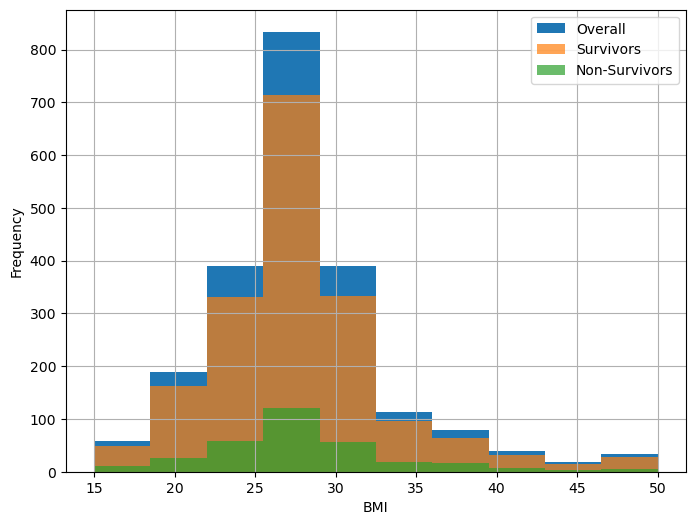

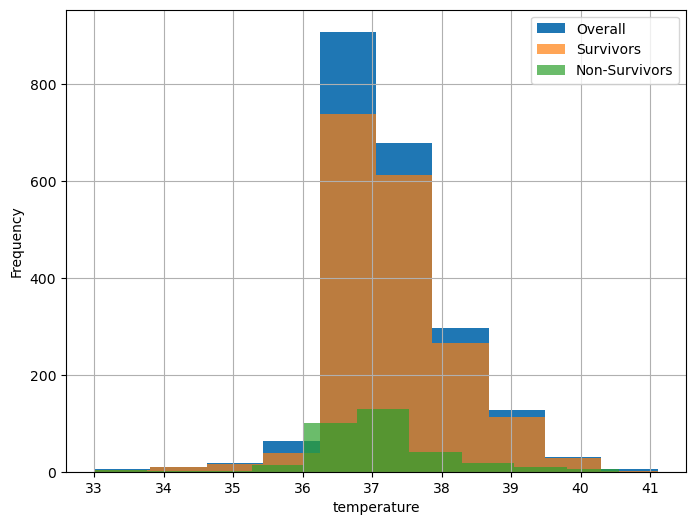

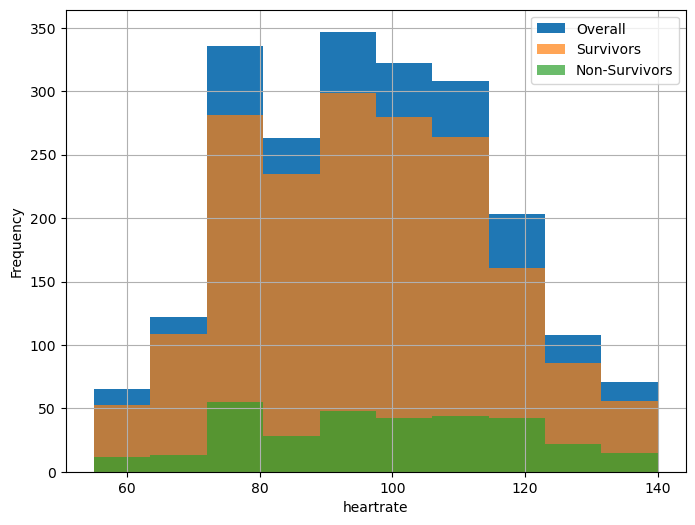

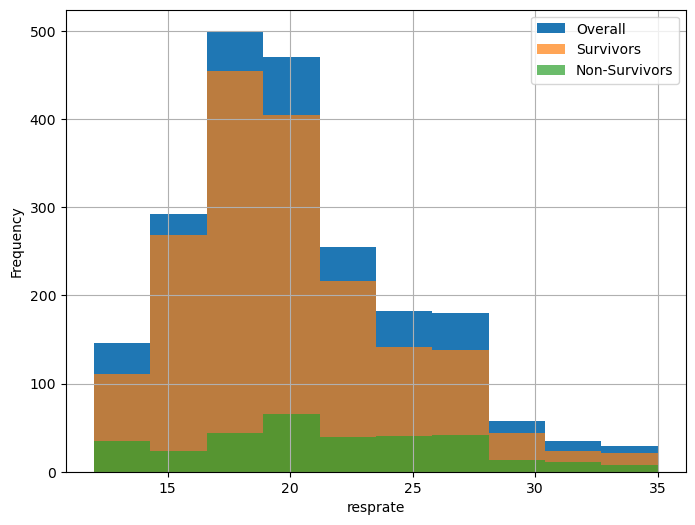

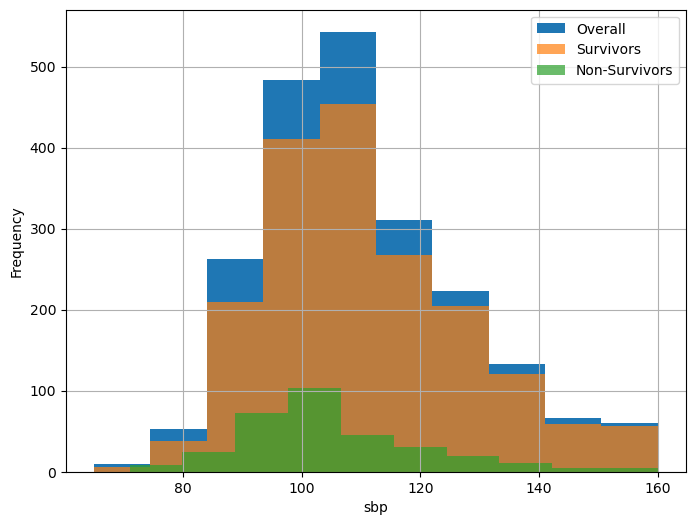

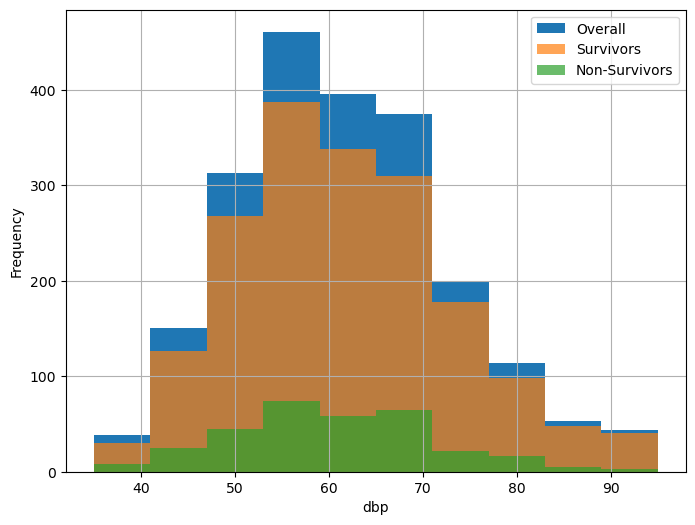

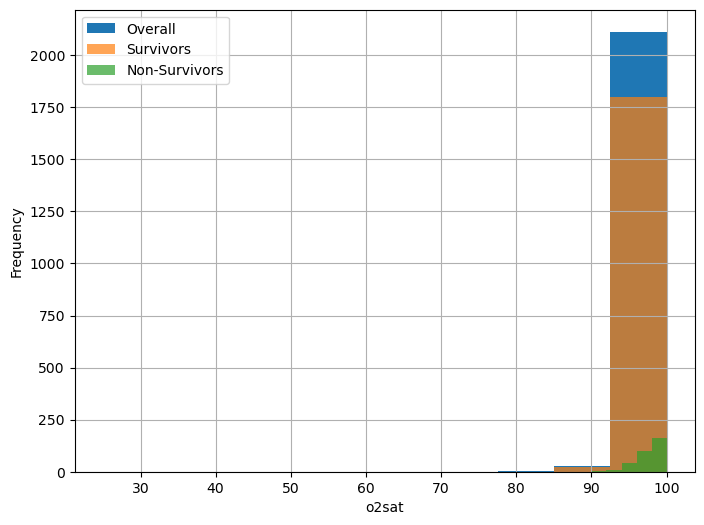

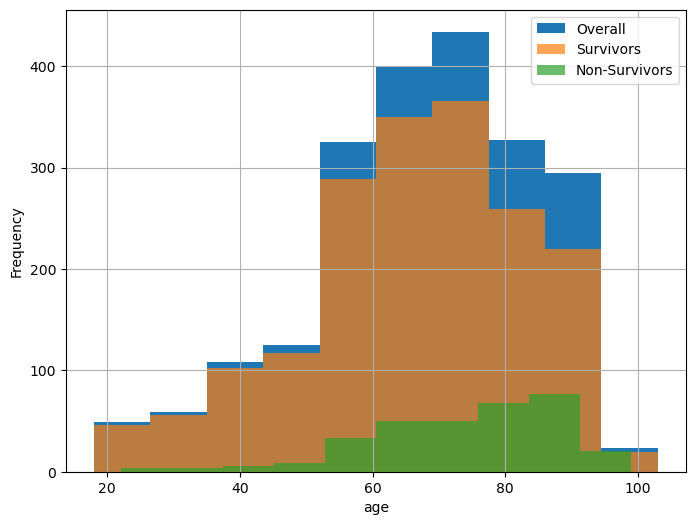

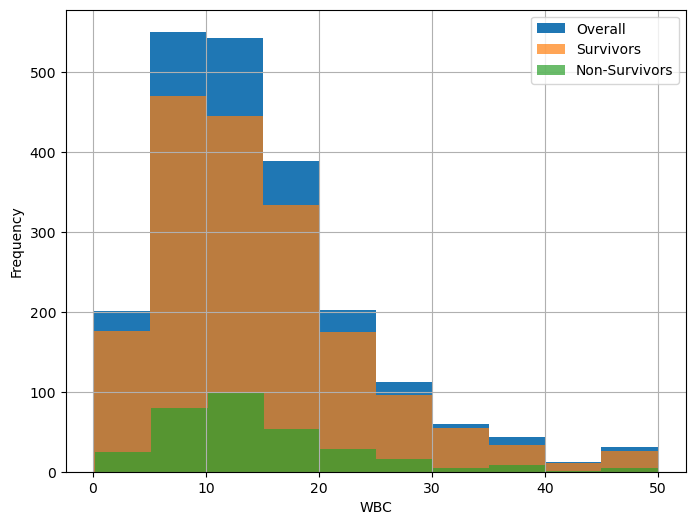

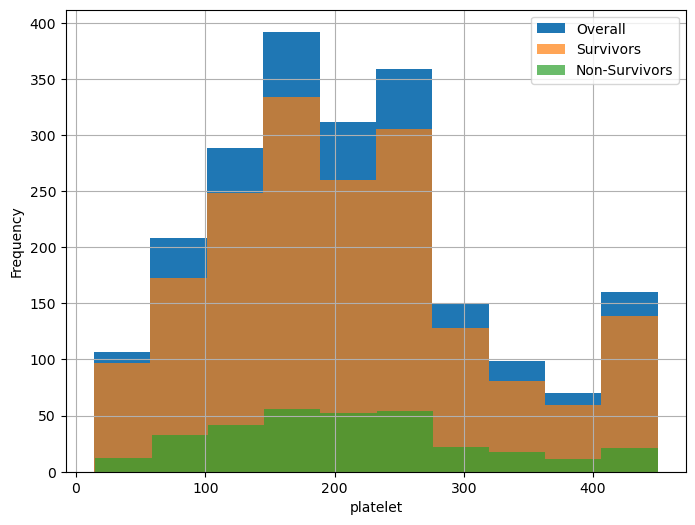

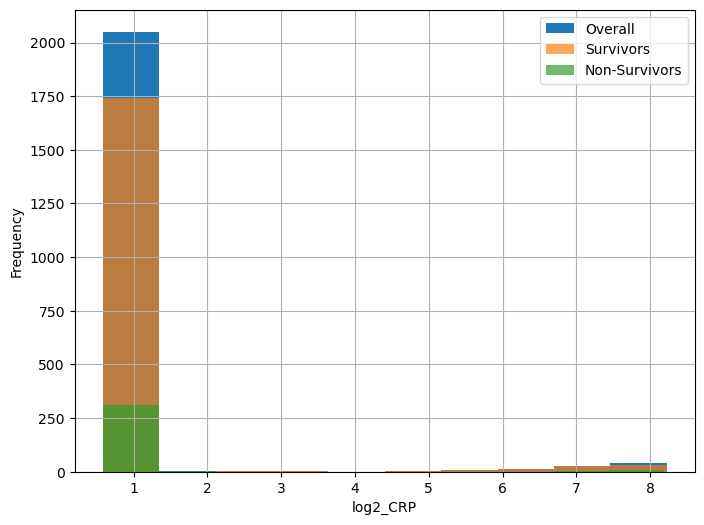

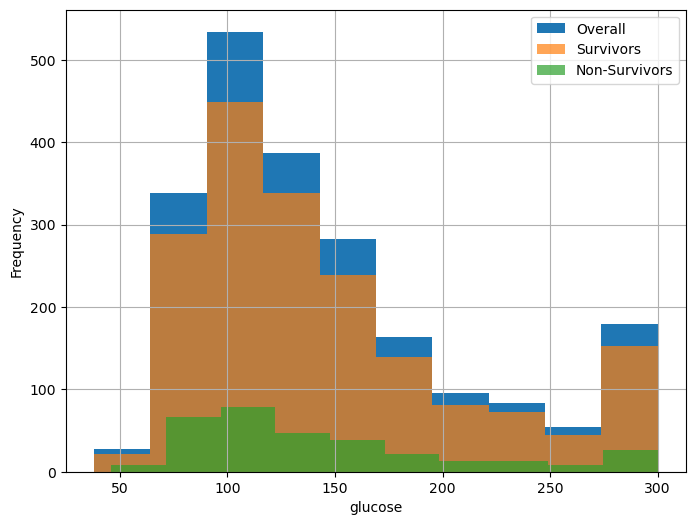

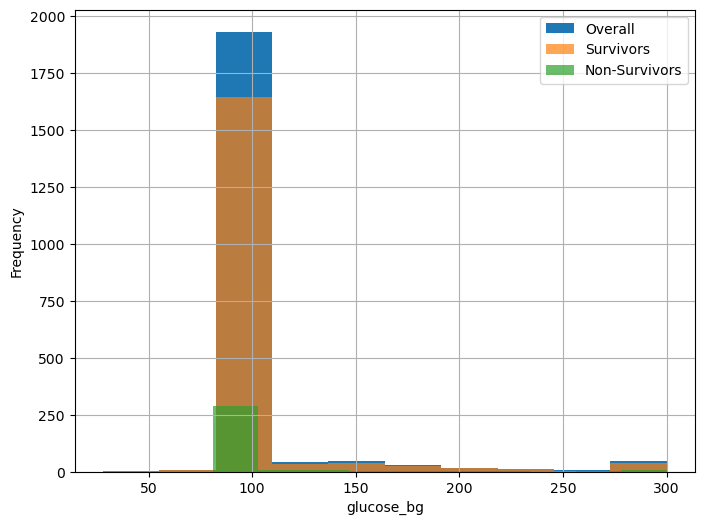

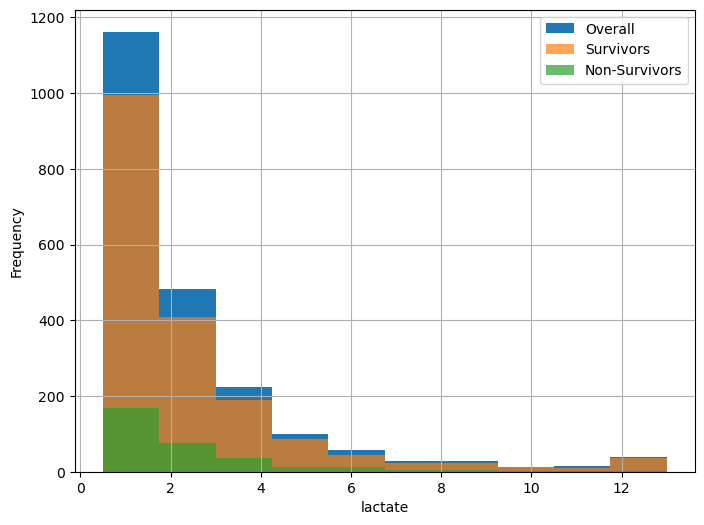

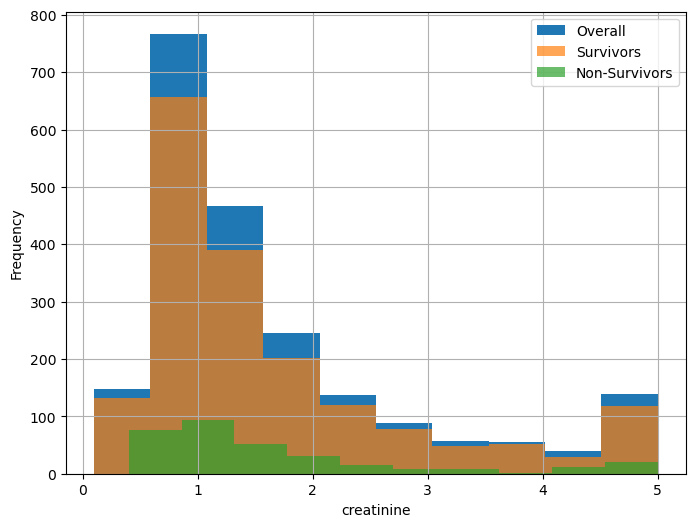

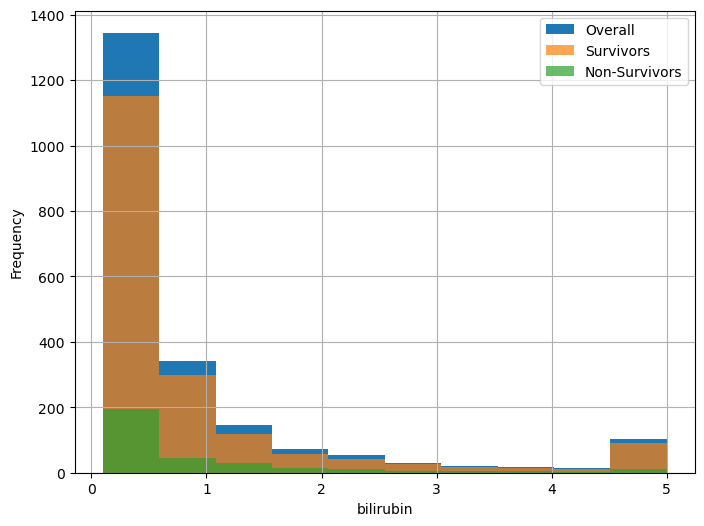

In [22]:
for col in numeric_variables:
    fig, ax = plt.subplots(figsize=(8, 6))
    # plot the histogram for overall
    df[col].hist(ax=ax, label='Overall')
    # plot the histogram for survivors
    df[df['death'] == 0][col].hist(ax=ax, alpha=0.7, label='Survivors')
    # plot the histogram for non-survivors
    df[df['death'] == 1][col].hist(ax=ax, alpha=0.7, label='Non-Survivors')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.legend()
    #fig.savefig(f'{col}_histogram.png')
    plt.show()


In [23]:
results_num_df = pd.DataFrame()


def perform_statistical_tests(column):
    # Check for normality using the Shapiro-Wilk test
    stat, p_shapiro_survivors = shapiro(survivors[column])
    stat, p_shapiro_non_survivors = shapiro(non_survivors[column])
    
    if p_shapiro_survivors > 0.05 and p_shapiro_non_survivors > 0.05:
        # Normally distributed data: use Student's t-test
        stat, p = ttest_ind(survivors[column], non_survivors[column])
        print(f"Student's t-test p-value for {column}: {p:.5f}")
    else:
        # Non-normally distributed data: use Mann-Whitney test
        stat, p = mannwhitneyu(survivors[column], non_survivors[column])
        print(f"Mann-Whitney test p-value for {column}: {p:.5f}")
    p_values[column] = p

In [24]:
for variable in numeric_variables:
    perform_statistical_tests(variable)

Mann-Whitney test p-value for BMI: 0.39890
Mann-Whitney test p-value for temperature: 0.00000
Mann-Whitney test p-value for heartrate: 0.02902
Mann-Whitney test p-value for resprate: 0.00000
Mann-Whitney test p-value for sbp: 0.00000
Mann-Whitney test p-value for dbp: 0.09211
Mann-Whitney test p-value for o2sat: 0.03154
Mann-Whitney test p-value for age: 0.00000
Mann-Whitney test p-value for WBC: 0.99852
Mann-Whitney test p-value for platelet: 0.57850
Mann-Whitney test p-value for log2_CRP: 0.53924
Mann-Whitney test p-value for glucose: 0.66867
Mann-Whitney test p-value for glucose_bg: 0.62382
Mann-Whitney test p-value for lactate: 0.67432
Mann-Whitney test p-value for creatinine: 0.16780
Mann-Whitney test p-value for bilirubin: 0.26942


In [25]:
# Filter predictor variables with p-value ≤ 0.05
significant_predictors = [var for var, p_value in p_values.items() if p_value <= 0.05]
print("\nSignificant predictor variables (p-value ≤ 0.05):")
print(significant_predictors)


Significant predictor variables (p-value ≤ 0.05):
['myocardial_infarction', 'cerebrovascular_disease', 'diabetes_with_chronic_complication', 'malignancy', 'metastatic_solid_tumor', 'diabetes_mellitus', 'IV', 'HFNC', 'gcs_geq', 'invasive_ventilation', 'qsofa', 'temperature', 'heartrate', 'resprate', 'sbp', 'o2sat', 'age']


In [26]:

for col in numeric_variables:
    
    # Calculate the median and IQR for this variable among all patients
    overall_median = df[col].median()
    # Calculate the 25th and 75th percentiles of the 'age' column
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)

    # Calculate the IQR of the 'age' column
    overall_iqr = q3 - q1
    
    # Calculate the median and IQR for this variable among survivors (death=0)
    survivor_median = df[df['death'] == 0][col].median()
    survivor_q1 = df[df['death'] == 0][col].quantile(0.25)
    survivor_q3 = df[df['death'] == 0][col].quantile(0.75)
    survivor_iqr = survivor_q3 - survivor_q1
    
    
    # Calculate the number and proportion of 1's for non-survivors
    nonsurvivor_median = df[df['death'] == 1][col].median()
    nonsurvivor_q1 = df[df['death'] == 1][col].quantile(0.25)
    nonsurvivor_q3 = df[df['death'] == 1][col].quantile(0.75)
    nonsurvivor_iqr = survivor_q3 - survivor_q1
    
    
    # Add the results to the new dataframe
    results_num_df.loc[col, 'Overall Median'] = overall_median
    results_num_df.loc[col, 'Overall IQR'] = overall_iqr
    results_num_df.loc[col, 'Survivor Median'] = survivor_median
    results_num_df.loc[col, 'Survivor IQR'] = survivor_iqr
    results_num_df.loc[col, 'Non-Survivor Median'] = nonsurvivor_median
    results_num_df.loc[col, 'Non-Survivor IQR'] = nonsurvivor_iqr
    results_num_df.loc[col, 'P value'] = p_values[col]

In [27]:
results_num_df.head(5)

,Overall Median,Overall IQR,Survivor Median,Survivor IQR,Non-Survivor Median,Non-Survivor IQR,P value
BMI,27.270000,4.955288,27.222222,4.975568,27.4,4.975568,3.989036e-01
temperature,37.111111,1.000000,37.111111,1.000000,37.0,1.000000,5.445457e-09
heartrate,96.000000,29.000000,95.500000,28.000000,99.0,28.000000,2.902484e-02
resprate,20.000000,5.500000,19.000000,5.000000,21.0,5.000000,9.294578e-08
sbp,106.000000,22.500000,107.000000,23.000000,104.0,23.000000,6.311451e-07


In [28]:
#Fix log2_CRP to CRP
col =  'log2_CRP'
results_num_df.loc[col, 'Overall Median'] = np.exp(overall_median * np.log(2))
results_num_df.loc[col, 'Overall IQR'] = np.exp(overall_iqr * np.log(2))
results_num_df.loc[col, 'Survivor Median'] = np.exp(survivor_median * np.log(2))
results_num_df.loc[col, 'Survivor IQR'] = np.exp(survivor_iqr * np.log(2))
results_num_df.loc[col, 'Non-Survivor Median'] = np.exp(nonsurvivor_median * np.log(2)) 
results_num_df.loc[col, 'Non-Survivor IQR'] = np.exp(nonsurvivor_iqr * np.log(2))
df.rename(columns={col: 'CRP'}, inplace=True)

Add missing value percents to each variable

In [29]:
# define the file path and column names
file_path = 'sepsis.csv'

In [30]:
cols = pd.DataFrame({'numbers': df.columns})


In [31]:
df2 = pd.read_csv(file_path)
df2['use_of_vasopressors'] = df2[['epinephrine', 'norepinephrine', 'dopamine', 'dobutamine']].sum(axis=1, skipna=False)
df2['use_of_vasopressors'] = df2['use_of_vasopressors'].apply(lambda x: 1 if pd.notna(x) and x > 0 else (0 if pd.notna(x) and x == 0 else np.nan))

# create a new variable 'Invasive ventilation'
df2['invasive_ventilation'] = df2[['tracheostomy', 'IV']].sum(axis=1, skipna=False)
df2['invasive_ventilation'] = df2['invasive_ventilation'].apply(lambda x: 1 if pd.notna(x) and x > 0 else (0 if pd.notna(x) and x == 0 else np.nan))


# create a new variable 'Non invasive ventilation'
df2['non_invasive_ventilation'] = df2[['NIV', 'HFNC']].sum(axis=1, skipna=False)
df2['non_invasive_ventilation'] = df2['non_invasive_ventilation'].apply(lambda x: 1 if pd.notna(x) and x > 0 else (0 if pd.notna(x) and x == 0 else np.nan))

# create a new variable 'Non invasive ventilation'
df2['qsofa'] = df2[['resprate_first', 'gcs', 'sbp_first']].sum(axis=1, skipna=False)
df2['qsofa'] = df2['qsofa'].apply(lambda x: 1 if pd.notna(x) and x > 0 else (0 if pd.notna(x) and x == 0 else np.nan))


In [32]:
# compute the missing value percentages for the categorical variables
cat_missing_perc = []
for var in categorical_variables:
    if var == 'po2_fio2_geq':
        var = 'po2/fio2'
    if var == 'gcs_geq':
        var = 'gcs'
    cat_missing_perc.append(df2[var].isna().mean())


In [33]:
len(cat_missing_perc)

35

In [34]:
results_cat_df['missing data'] = cat_missing_perc

In [35]:
numeric_variables_modified = [
    'BMI', 'temperature_first', 'heartrate_first', 'resprate_first', 'sbp_first', 'dbp_first',
    'o2sat_first', 'age',
    'WBC_ED', 'platelet_ED', 'CRP', 'glucose_ED', 'glucose_bg_ED', 'lactate_ED', 'creatinine_ED', 'bilirubin_ED'
]

# compute the missing value percentages for the numeric variables
num_missing_perc = [df2[var].isna().mean() for var in numeric_variables_modified]

In [36]:
num_missing_perc

[0.38514383855732076,
 0.3233147273507943,
 0.12966938600257621,
 0.1468441391155002,
 0.14340918849291542,
 0.14340918849291542,
 0.18162301416917132,
 0.0,
 0.8608844997853156,
 0.8617432374409618,
 0.9557750107342207,
 0.8634607127522542,
 0.991412623443538,
 0.8673250322026621,
 0.8617432374409618,
 0.905968226706741]

In [37]:
results_num_df['missing data'] = num_missing_perc

In [38]:
 
writer = pd.ExcelWriter('results.xlsx')

# Write the results_num_df dataframe to the 'Numeric Results' sheet
results_num_df.to_excel(writer, sheet_name='Numeric Results')

# Write the results_cat_df dataframe to the 'Categorical Results' sheet
results_cat_df.to_excel(writer, sheet_name='Categorical Results')

# Save the Excel file
writer.save()

In [39]:
import statsmodels.api as sm

In [40]:
variables_sig = ['myocardial_infarction', 'cerebrovascular_disease', 
 'diabetes_with_chronic_complication', 'malignancy', 
                 'metastatic_solid_tumor',  
                 'invasive_ventilation', 'temperature', 'heartrate',
                  'qsofa', 'age']

In [41]:
variables_domain = ['lactate' ,'diabetes_without_chronic_complication',
                    'moderate_or_severe_liver_disease', 'renal_disease',
                    'creatinine','use_of_vasopressors']

In [42]:
df['EDTime'] = df['EDTime'] * 24

In [43]:
# create new variables for each category of EDTime
df['EDTime_3'] = (df['EDTime'] < 3).astype(int)
df['EDTime_6'] = (df['EDTime'] < 6).astype(int)
df['EDTime_12'] = (df['EDTime'] < 12).astype(int)
df['EDTime_24'] = (df['EDTime'] < 24).astype(int)

In [44]:
# create a list of all variables to include in the model
#variables = variables_sig + variables_domain + ['EDTime', 'WHITE', 'congestive_heart_failure']

In [45]:
var = [ 'BMI', 'weight', 'age', 'myocardial_infarction',
       'congestive_heart_failure', 'peripheral_vascular_disease',
       'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease',
       'rheumatic_disease', 'peptic_ulcer_disease', 'mild_liver_disease',
       'diabetes_without_chronic_complication',
       'diabetes_with_chronic_complication', 'hemiplegia_or_paraplegia',
       'renal_disease', 'malignancy', 'moderate_or_severe_liver_disease',
       'metastatic_solid_tumor', 'AIDSHIV', 'hypertension',
       'diabetes_mellitus', 'log2_num_admissions', 'log2_num_ED',
       'log2_num_ED_admissions', 'WBC', 'platelet', 'CRP', 'glucose',
       'glucose_bg', 'lactate', 'creatinine', 'bilirubin', 'po2_fio2_geq', 'gcs_geq',
       'epinephrine', 'norepinephrine', 'dopamine', 'dobutamine',
       'tracheostomy', 'IV', 'NIV', 'HFNC', 'supplemental_oxygen',
       'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'qsofa', 'use_of_vasopressors',
       'invasive_ventilation', 'non_invasive_ventilation'
       ]

In [46]:
time_list = ['EDTime_3','EDTime_6', 'EDTime_12','EDTime_24']
or_dfs = []

In [47]:
time_list = ['EDTime']

In [68]:
from sklearn.preprocessing import StandardScaler


var_use = var + [time_range]

for time_range in time_list:
    
    X = df[var_use]
    scaler = StandardScaler()
    X_STD = scaler.fit_transform(X)
    # fit a logistic regression model with all variables
    X_STD = sm.add_constant(X_STD)
    y = df['death']
    logit_model = sm.Logit(y, X_STD)
    result = logit_model.fit(maxiter=100)
    
    # calculate adjusted odds ratios for each variable
    ORs = np.exp(result.params)
    CI = np.exp(result.conf_int(alpha=0.01))
    CI.columns = ['OR_lower', 'OR_upper']
    ORs = pd.concat([ORs, CI], axis=1)
    ORs.columns = ['OR', 'OR_lower', 'OR_upper']
    ORs.drop('const', inplace=True)
    #ORs = ORs.loc[var_use]
    or_dfs.append(ORs)
    

    print(ORs)

Optimization terminated successfully.
         Current function value: 0.311617
         Iterations 7
           OR  OR_lower   OR_upper
x1   1.116441  0.800917   1.556268
x2   0.954944  0.684617   1.332011
x3   1.764001  1.390225   2.238270
x4   1.241540  1.016844   1.515889
x5   0.965924  0.754343   1.236850
x6   1.011380  0.815597   1.254162
x7   1.158067  0.942276   1.423277
x8   0.925526  0.766614   1.117378
x9   0.993064  0.799388   1.233664
x10  1.031376  0.832894   1.277156
x11  0.992943  0.811373   1.215146
x12  0.983345  0.766756   1.261113
x13  1.192211  0.751444   1.891514
x14  0.843079  0.650446   1.092759
x15  0.927618  0.742264   1.159259
x16  1.231397  0.977157   1.551787
x17  1.169628  0.917567   1.490930
x18  1.148091  0.927292   1.421464
x19  1.241767  1.002204   1.538594
x20  0.925246  0.698110   1.226282
x21  0.895388  0.687689   1.165818
x22  0.829923  0.523838   1.314858
x23  1.028358  0.644769   1.640154
x24  0.637164  0.275900   1.471468
x25  1.191316  0.502783

In [69]:
var_use_df = pd.DataFrame(var_use, columns=['Variable'])


In [70]:
filename = 'odds_ratios_final.xlsx'
with pd.ExcelWriter(filename) as writer:
    or_dfs[0].to_excel(writer, sheet_name='Sheet1', index=False)
    var_use_df.to_excel(writer, sheet_name='Sheet2', index=False)


In [67]:
# Write the list of DataFrames to a single Excel file with separate sheets
with pd.ExcelWriter('odds_ratios_final.xlsx') as writer:
    for i, df_or in enumerate(or_dfs):
        df_or.to_excel(writer, sheet_name=time_list[i])

IndexError: list index out of range

In [ ]:
or_file = pd.DataFrame(ORs)

# Save the DataFrame to an Excel file
or_file.to_excel('or_file_new_group.xlsx', index=True)

In [ ]:
# Create the plot
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.regplot(x='EDTime', y='death', data=df, logistic=True, ci=95, scatter=False, line_kws={'color': 'red', 'label': 'Fitted Line'})
#plt.fill_between(df_sorted['EDTime'], lower_conf_int[0], upper_conf_int[0], color='gray', alpha=0.3, label="95% CI")
plt.xlabel('Length of Stay in ED')
plt.ylabel('Adjusted Probability of Hospital Mortality')
plt.title('Adjusted Probability of Hospital Mortality vs. Length of Stay in ED')
plt.legend()
plt.show()